In [1]:
import pandas as pd 
import numpy as np
import os
from functools import reduce
import re
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, MinMaxScaler, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, mean_squared_error, median_absolute_error
from sklearn.metrics import accuracy_score, hamming_loss, f1_score, classification_report

import utilities as utils
import rdkit_helper
import model
import plot

In [2]:
data_config = {
    'index_col' : 'CHEMICAL ID',
    'chem_id_col' : 'CHEMICAL ID',
    'chem_id_type_col' : 'CHEMICAL ID TYPE',
}

path_config = {
    'cdr_file' : 'Input/Raw/CDR/2020/2020 CDR Industrial Processing and Use Information.csv',
    'smi_file' : 'Input/Raw/CDR/2020/chemical_ids.smi'
}

In [3]:
cdr_data = utils.load_cdr_data(path_config['cdr_file'], data_config)

cdr_data.head()

C:\Users\jmank\Repositories\ht_occupational_plus\utilities.py:30: DtypeWarning: Columns (71) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(csv_file).dropna(how='all')


,CHEMICAL REPORT ID,CHEMICAL NAME,CHEMICAL ID W/O DASHES,CHEMICAL ID TYPE,DOMESTIC PARENT COMPANY NAME,DOMESTIC PC ADDRESS LINE1,DOMESTIC PC ADDRESS LINE2,DOMESTIC PC CITY,DOMESTIC PC COUNTY / PARISH,DOMESTIC PC STATE,...,INDUSTRIAL FUNCTION CATEGORY,IND FUNCT CAT OTHER DESC,JOINT FC CODE,JOINT FUNCTION CATEGORY,JOINT FUNCT CAT OTHER DESC,IND PV PCT,IND SITES CODE,INDUSTRIAL SITES,IND WORKERS CODE,INDUSTRIAL WORKERS
CHEMICAL ID,,,,,,,,,,,,,,,,,,,,,
10016-20-3,720823.0,.alpha.-Cyclodextrin,10016203.0,CASRN,WACKER CHEMICAL CORPORATION,3301 SUTTON ROAD,NaN,ADRIAN,Lenawee,MI,...,Agricultural chemicals (non-pesticidal),NaN,NaN,NaN,NaN,CBI,CBI,CBI,CBI,CBI
128446-33-3,730172.0,".alpha.-Cyclodextrin, 2-hydroxypropyl ethers",128446333.0,CASRN,CBI,CBI,CBI,CBI,CBI,CBI,...,Not Known or Reasonably Ascertainable,NaN,NaN,NaN,NaN,100,S1,< 10,W5,100 – 499
128446-33-3,720826.0,".alpha.-Cyclodextrin, 2-hydroxypropyl ethers",128446333.0,CASRN,WACKER CHEMICAL CORPORATION,3301 SUTTON ROAD,NaN,ADRIAN,Lenawee,MI,...,Solubility enhancer,NaN,NaN,NaN,NaN,CBI,CBI,CBI,CBI,CBI
56038-13-2,729853.0,".alpha.-D-Galactopyranoside, 1,6-dichloro-1,6-...",56038132.0,CASRN,"Brenntag Mid-South, Inc.",1405 Highway 136 West,NaN,Henderson,Henderson,KY,...,Not Known or Reasonably Ascertainable,NaN,NaN,NaN,NaN,100,NKRA,Not Known or Reasonably Ascertainable,NKRA,Not Known or Reasonably Ascertainable
99-20-7,710671.0,".alpha.-D-Glucopyranoside, .alpha.-D-glucopyra...",99207.0,CASRN,CBI,CBI,CBI,CBI,CBI,CBI,...,Other (specify),"Culture medium, stabilizer",NaN,NaN,NaN,100,S1,< 10,W2,10 – 24


In [4]:
cdr_data['SITE NAICS CODE 1'].unique()

array(['311221 Wet Corn Milling', 'CBI',
       '424690 Other Chemical And Allied Products Merchant Wholesalers',
       '322220 Paper Bag And Coated And Treated Paper Manufacturing',
       '325180 Other Basic Inorganic Chemical Manufacturing',
       '325998 All Other Miscellaneous Chemical Product And Preparation Manufacturing',
       '325199 All Other Basic Organic Chemical Manufacturing',
       '111930 Sugarcane Farming',
       '325611 Soap And Other Detergent Manufacturing',
       '325613 Surface Active Agent Manufacturing',
       '424910 Farm Supplies Merchant Wholesalers',
       '339942 Lead Pencil And Art Good Manufacturing',
       '325130 Synthetic Dye And Pigment Manufacturing',
       '325910 Printing Ink Manufacturing',
       '325132 Synthetic Organic Dye And Pigment Manufacturing',
       '541712 Research And Development In The Physical, Engineering, And Life Sciences (Except Biotechnology)',
       '324110 Petroleum Refineries',
       '325110 Petrochemical Manuf

In [5]:
cdr_data['2019 DOMESTIC PV']

CHEMICAL ID
10016-20-3         CBI
128446-33-3    141,314
128446-33-3        CBI
56038-13-2           0
99-20-7            CBI
                ...   
7699-43-6          CBI
7699-43-6          NaN
113184-20-6        CBI
101033-44-7        CBI
101033-44-7        CBI
Name: 2019 DOMESTIC PV, Length: 64138, dtype: object

In [6]:
cdr_data['WORKERS'].unique()

array(['CBI', '100 – 499', nan, 'Not Known or Reasonably Ascertainable',
       '10 – 24', '< 10', '50 – 99', '25 – 49', '1,000 – 9,999',
       '500 – 999', '10,000+'], dtype=object)

In [7]:
cdr_data['MAXIMUM CONCENTRATION'].unique()

array(['CBI', '30% – < 60%', nan, 'Not Known or Reasonably Ascertainable',
       '90% +', '1% – < 30%', '60% – < 90%', '< 1%'], dtype=object)

In [8]:
set([form for forms in cdr_data['PHYSICAL FORM(S)'].str.split(',').dropna() for form in forms])

{' Gas or Vapor',
 ' Liquid',
 ' NKRA',
 ' Other Solid',
 ' Pellets or Large Crystals',
 ' Water or Solvent Wet Solid',
 'CBI',
 'Dry Powder',
 'Gas or Vapor',
 'Liquid',
 'NKRA',
 'Other Solid',
 'Pellets or Large Crystals',
 'Water or Solvent Wet Solid'}

In [9]:
cdr_data['INDUSTRIAL FUNCTION CATEGORY'].unique()

array(['Agricultural chemicals (non-pesticidal)',
       'Not Known or Reasonably Ascertainable', 'Solubility enhancer',
       'Other (specify)', nan, 'Laboratory chemicals',
       'Plating agents and surface treating agents',
       'Paint additives and coating additives not described by other categories',
       'Absorbent', 'Processing aids, specific to petroleum production',
       'Surfactant (surface active agent)', 'Cleaning agent',
       'Adhesives and sealant chemicals',
       'Processing aids, not otherwise listed', 'Surface active agents',
       'Viscosity adjustors', 'Finishing agents',
       'Processing aids not otherwise specified', 'Surface modifier',
       'Odor agents', 'Solids separation agents', 'Deodorizer',
       'Intermediate', 'Intermediates', 'Pigments', 'Dye', 'Dyes',
       'Fuels and fuel additives', 'Heat transferring agent',
       'Functional fluids (closed systems)', 'Plasticizers',
       'Plasticizer', 'pH regulating agent',
       'Aerating and

In [10]:
naics_cols = [c for c in cdr_data if 'SITE NAICS CODE' in c]
combined_subsectors = utils.extract_subsectors(cdr_data[naics_cols])
combined_subsectors

CHEMICAL ID
10016-20-3     [3112, 4246]
128446-33-3              []
128446-33-3    [3112, 4246]
56038-13-2           [4246]
99-20-7                  []
                   ...     
7699-43-6            [3251]
7699-43-6            [4246]
113184-20-6    [3251, 3251]
101033-44-7          [4246]
101033-44-7          [4246]
Length: 64138, dtype: object

In [11]:
combined_sectors = utils.extract_sectors(combined_subsectors)
combined_sectors

CHEMICAL ID
10016-20-3     [42, 31]
128446-33-3          []
128446-33-3    [42, 31]
56038-13-2         [42]
99-20-7              []
                 ...   
7699-43-6          [32]
7699-43-6          [42]
113184-20-6        [32]
101033-44-7        [42]
101033-44-7        [42]
Length: 64138, dtype: object

In [12]:
subsector_data = utils.create_binary_data(
    combined_subsectors, 
    by=data_config['chem_id_col'],
    agg_func='max'
)

subsector_data

,3342,3273,9241,3326,3112,3133,3315,3253,4242,5629,...,4233,5231,5232,3351,3321,3327,3322,3221,3311,3361
CHEMICAL ID,,,,,,,,,,,,,,,,,,,,,
100-01-6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-10-7,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
100-15-2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100-18-5,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
100-20-9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99742-80-0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998-30-1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998-40-3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
sector_data = utils.create_binary_data(
    combined_sectors, 
    by=data_config['chem_id_col'],
    agg_func='max'
)

sector_data

,31,11,55,21,48,92,52,81,42,23,32,44,54,49,45,22,33,56
CHEMICAL ID,,,,,,,,,,,,,,,,,,
100-01-6,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
100-10-7,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
100-15-2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
100-18-5,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
100-20-9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99742-80-0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
998-30-1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
998-40-3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0


In [14]:
physical_forms = utils.extract_physical_forms(cdr_data['PHYSICAL FORM(S)'])

physical_forms

CHEMICAL ID
10016-20-3                            [Dry Powder]
128446-33-3                               [Liquid]
128446-33-3                                     []
56038-13-2                            [Dry Powder]
99-20-7                               [Dry Powder]
                              ...                 
7699-43-6      [Pellets or Large Crystals, Liquid]
7699-43-6                                       []
113184-20-6                               [Liquid]
101033-44-7                                     []
101033-44-7                                     []
Name: PHYSICAL FORM(S), Length: 64138, dtype: object

In [15]:
forms_data = utils.create_binary_data(
    physical_forms, 
    by=data_config['chem_id_col'],
    agg_func='max'
)

forms_data

,Gas or Vapor,Other Solid,Dry Powder,Pellets or Large Crystals,Water or Solvent Wet Solid,NKRA,Liquid
CHEMICAL ID,,,,,,,
100-01-6,0,0,1,0,0,0,0
100-10-7,0,0,1,0,0,0,0
100-15-2,0,0,0,0,0,0,0
100-18-5,1,0,0,0,0,0,1
100-20-9,0,0,1,1,0,0,0
...,...,...,...,...,...,...,...
99742-80-0,0,0,0,0,0,0,1
998-30-1,0,0,0,0,0,0,1
998-40-3,0,0,0,0,0,0,1


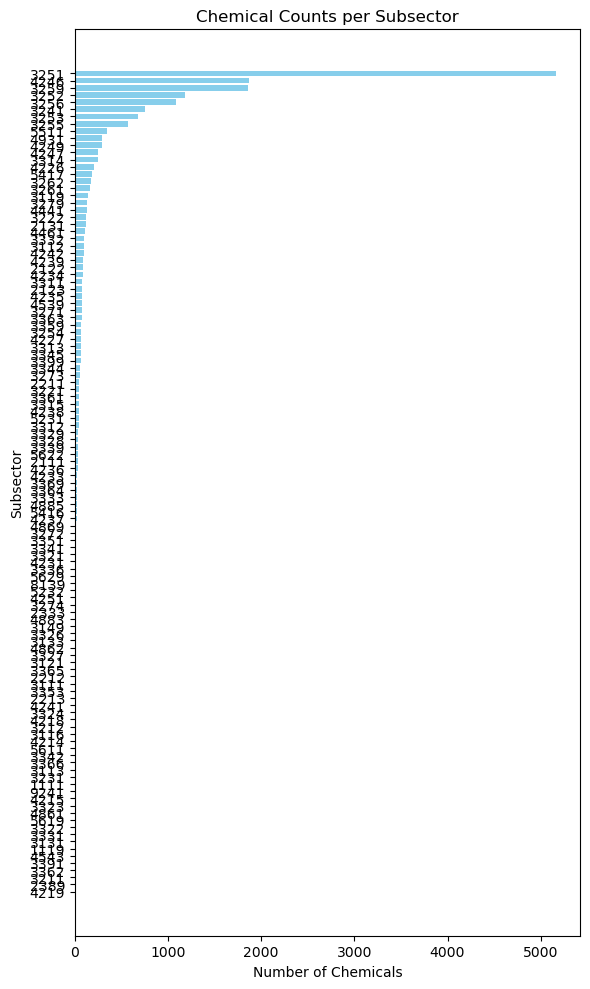

In [16]:
subsector_counts = subsector_data.sum()

_ = plot.chemical_counts(
    subsector_counts, 
    'Chemical Counts per Subsector', 
    'Number of Chemicals', 
    'Subsector'
)

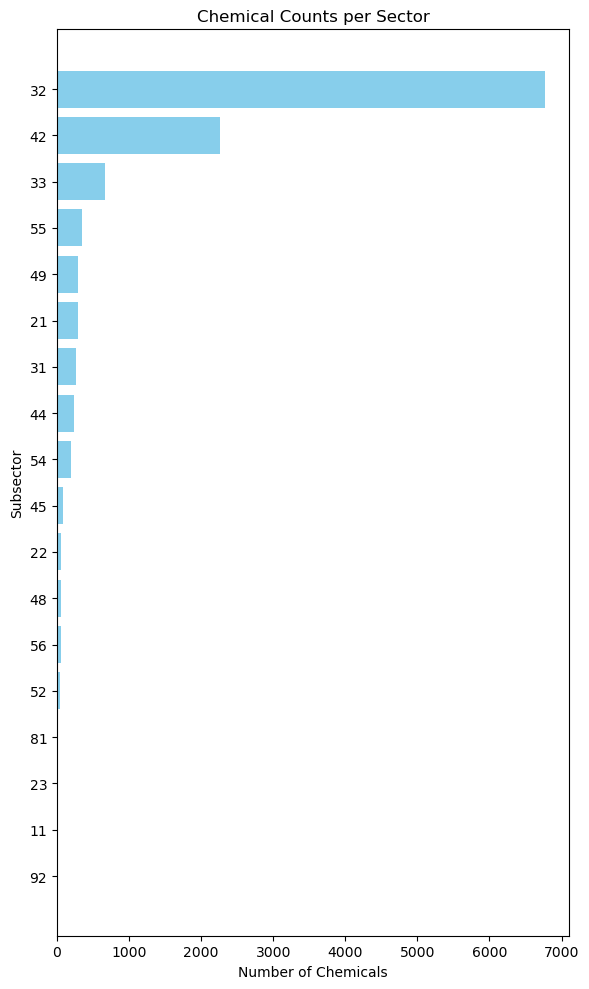

In [17]:
sector_counts = sector_data.sum()

_ = plot.chemical_counts(
    sector_counts, 
    'Chemical Counts per Sector', 
    'Number of Chemicals', 
    'Subsector'
)

In [18]:
continuous_cols = [
    '2019 DOMESTIC PV',
    'MAXIMUM CONCENTRATION',
    'WORKERS'
]

cdr_data[continuous_cols]

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
CHEMICAL ID,,,
10016-20-3,CBI,CBI,CBI
128446-33-3,"141,314",30% – < 60%,100 – 499
128446-33-3,CBI,NaN,NaN
56038-13-2,0,Not Known or Reasonably Ascertainable,Not Known or Reasonably Ascertainable
99-20-7,CBI,90% +,10 – 24
...,...,...,...
7699-43-6,CBI,30% – < 60%,10 – 24
7699-43-6,NaN,NaN,NaN
113184-20-6,CBI,30% – < 60%,< 10


In [19]:
cdr_data['2019 DOMESTIC PV']

CHEMICAL ID
10016-20-3         CBI
128446-33-3    141,314
128446-33-3        CBI
56038-13-2           0
99-20-7            CBI
                ...   
7699-43-6          CBI
7699-43-6          NaN
113184-20-6        CBI
101033-44-7        CBI
101033-44-7        CBI
Name: 2019 DOMESTIC PV, Length: 64138, dtype: object

In [20]:
cdr_data['MAXIMUM CONCENTRATION'].unique()

array(['CBI', '30% – < 60%', nan, 'Not Known or Reasonably Ascertainable',
       '90% +', '1% – < 30%', '60% – < 90%', '< 1%'], dtype=object)

In [21]:
cdr_data['WORKERS'].unique()

array(['CBI', '100 – 499', nan, 'Not Known or Reasonably Ascertainable',
       '10 – 24', '< 10', '50 – 99', '25 – 49', '1,000 – 9,999',
       '500 – 999', '10,000+'], dtype=object)

In [22]:
kwargs_for_col = {
    '2019 DOMESTIC PV' : {
        'agg_func' : 'median'
    },
    'MAXIMUM CONCENTRATION' : {
        'lower_bound' : 0., 
        'upper_bound' : 100.,
        'agg_func' : 'median'
    },
    'WORKERS' : {
        'lower_bound' : 1, 
        'upper_bound' : 15000,
        'agg_func' : 'median'
    }
}

continuous_data = utils.create_continuous_data(
    cdr_data[continuous_cols], 
    by=data_config['chem_id_col'],
    kwargs_for_col=kwargs_for_col
) 

continuous_data

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
CHEMICAL ID,,,
100-01-6,NaN,95.0,NaN
100-10-7,NaN,95.0,5.5
100-15-2,NaN,NaN,NaN
100-18-5,2075408.0,95.0,299.5
100-20-9,NaN,NaN,NaN
...,...,...,...
99742-80-0,0.0,NaN,NaN
998-30-1,340274.0,95.0,74.5
998-40-3,0.0,95.0,5.5


array([[<Axes: title={'center': '2019 DOMESTIC PV'}>,
        <Axes: title={'center': 'MAXIMUM CONCENTRATION'}>],
       [<Axes: title={'center': 'WORKERS'}>, <Axes: >]], dtype=object)

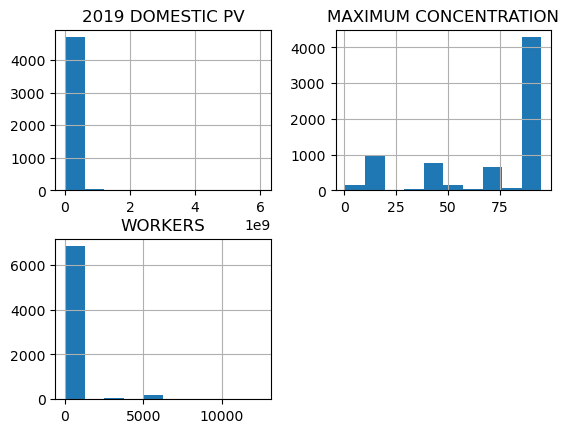

In [23]:
continuous_data.hist()

In [24]:
continuous_data.corr().round(2)

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
2019 DOMESTIC PV,1.00,0.09,0.17
MAXIMUM CONCENTRATION,0.09,1.00,0.04
WORKERS,0.17,0.04,1.00


In [25]:
smiles_for_casrn = utils.load_qsar_ready_smiles(path_config['smi_file'])

descriptors = rdkit_helper.get_2d_descriptors(
    smiles_for_casrn, 
    data_config['chem_id_col']
)

descriptors

[13:55:40] Explicit valence for atom # 4 B, 4, is greater than permitted
[13:55:40] Explicit valence for atom # 1 B, 4, is greater than permitted
[13:55:40] Can't kekulize mol.  Unkekulized atoms: 0 1 2 3 4
[13:55:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 16 17 18
[13:55:40] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 14 15 16 18 19 20 21 22 23
[13:55:40] Can't kekulize mol.  Unkekulized atoms: 10 11 12 13 15 16 17 19 20 21 25 27 28
[13:55:40] Can't kekulize mol.  Unkekulized atoms: 5 6 7 9 10 11 12 13 14 15 16 17 18


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
CHEMICAL ID,,,,,,,,,,,,,,,,,,,,,
10016-20-3,11.216799,-2.148030,11.216799,0.998871,0.117489,972.846,912.366,972.316941,384,0,...,0,0,0,0,0,0,0,0,0,0
128446-33-3,12.077597,-2.170340,12.077597,0.529048,0.060586,1205.166,1120.494,1204.484400,480,0,...,0,0,0,0,0,0,0,0,0,0
56038-13-2,10.149170,-1.897767,10.149170,0.125053,0.348881,397.635,378.483,396.014551,136,0,...,0,0,0,0,0,0,0,0,0,0
99-20-7,9.838983,-1.722065,9.838983,0.667174,0.243258,342.297,320.121,342.116212,136,0,...,0,0,0,0,0,0,0,0,0,0
57-50-1,9.997826,-2.221748,9.997826,0.668633,0.237891,342.297,320.121,342.116212,136,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67859-51-2,10.554993,-1.227529,10.554993,0.070278,0.333295,292.244,276.116,292.090665,114,0,...,0,0,0,0,0,0,0,0,0,0
14025-21-9,10.554993,-1.227529,10.554993,0.070278,0.333295,292.244,276.116,292.090665,114,0,...,0,0,0,0,0,0,0,0,0,0
14639-98-6,5.205391,0.627506,5.205391,0.627506,0.664511,273.426,258.306,273.064591,92,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
continuous_data

,2019 DOMESTIC PV,MAXIMUM CONCENTRATION,WORKERS
CHEMICAL ID,,,
100-01-6,NaN,95.0,NaN
100-10-7,NaN,95.0,5.5
100-15-2,NaN,NaN,NaN
100-18-5,2075408.0,95.0,299.5
100-20-9,NaN,NaN,NaN
...,...,...,...
99742-80-0,0.0,NaN,NaN
998-30-1,340274.0,95.0,74.5
998-40-3,0.0,95.0,5.5


In [27]:
discrete_descriptors = descriptors.select_dtypes('int')
all_features = pd.concat([discrete_descriptors, subsector_data], axis=1, join='inner')

regression_instructions = {
    '2019 Domestic PV (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : continuous_data['2019 DOMESTIC PV']
    }, 
    '2019 Domestic PV (w/ subsectors)' : {
        'X' : all_features, 
        'y' : continuous_data['2019 DOMESTIC PV']
    },
    'Max Conc. (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : continuous_data['MAXIMUM CONCENTRATION']
    }, 
    'Max Conc. (w/ subsectors)' : {
        'X' : all_features, 
        'y' : continuous_data['MAXIMUM CONCENTRATION'],        
    },
    'Workers (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : continuous_data['WORKERS']
    }, 
    'Workers (w/ subsectors)' : {
        'X' : all_features, 
        'y' : continuous_data['WORKERS'],        
    }
}

In [28]:
%%time

reg_results = {}  # initialize

for k, data in regression_instructions.items():
    
    res = model.regression_analysis(data['X'], data['y'])
    performances = model.evaluate_regression(res['y_test'], res['y_pred'])
    performances['N'] = len(res['y_train'])  # sample size

    reg_results[k] = {
        'y_test' : res['y_test'],
        'y_pred' : res['y_pred'],
        'performances' : performances
    }

CPU times: total: 8.36 s
Wall time: 13.3 s


In [29]:
pd.DataFrame({k : v['performances'] for k, v in reg_results.items()}).T

,R2,RMSE,MedAE,N
2019 Domestic PV (descriptors only),-0.007417,4.383145e+07,21.593724,2072.0
2019 Domestic PV (w/ subsectors),-0.008544,4.385596e+07,21.811963,2072.0
Max Conc. (descriptors only),0.075564,2.940078e+01,14.494956,3289.0
Max Conc. (w/ subsectors),0.223532,2.694524e+01,13.065757,3289.0
Workers (descriptors only),0.005302,6.867173e+02,16.353223,3236.0
Workers (w/ subsectors),0.021210,6.812038e+02,14.889653,3236.0


In [30]:
classification_instructions = {
    'Physical Form(s) (descriptors only)' : {
        'X' : discrete_descriptors, 
        'y' : forms_data
    }, 
    'Physical Form(s) (w/ subsectors)' : {
        'X' : all_features, 
        'y' : forms_data
    },
    'Sectors' : {
        'X' : discrete_descriptors,
        'y' : sector_data
    },
    'Subsectors' : {
        'X' : discrete_descriptors, 
        'y' : subsector_data
    }
}

In [31]:
class_results = {}  # initialize

for k, data in classification_instructions.items():

    res = model.classification_analysis(data['X'], data['y'])
    class_results[k] = {
        'y_test' : res['y_test'],
        'y_pred' : res['y_pred'],
        'performances' : classification_report(
            res['y_test'], 
            res['y_pred'], 
            target_names=list(data['y'])
        )
    }

C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmank\miniconda3\envs\chiu-lab\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\jmank\min

In [33]:
for k, results in class_results.items():
    print(k)
    print(results['performances'])

Physical Form(s) (descriptors only)
                            precision    recall  f1-score   support

              Gas or Vapor       0.58      0.39      0.47        18
               Other Solid       0.40      0.20      0.26       143
                Dry Powder       0.61      0.41      0.49       195
 Pellets or Large Crystals       0.41      0.16      0.23        92
Water or Solvent Wet Solid       0.50      0.21      0.29        34
                      NKRA       0.25      0.03      0.06        29
                    Liquid       0.82      0.88      0.85       655

                 micro avg       0.74      0.61      0.67      1166
                 macro avg       0.51      0.32      0.38      1166
              weighted avg       0.68      0.61      0.63      1166
               samples avg       0.68      0.63      0.63      1166

Physical Form(s) (w/ subsectors)
                            precision    recall  f1-score   support

              Gas or Vapor       0.56      